In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')                              # Linelist data 
climate_data = pd.read_csv('/Users/berhe/Desktop/ka-project/Temp-rain-humid/NASA-Temp-perc-humid.csv')          # Rainfall data can e dropped
ndvi_data_16d = pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/MODIS_NDVI_Lankien.csv')              # biweekly NDVI data                     
lst_data = pd.read_csv('/Users/berhe/Desktop/ka-project/MODIS_LST_Dataset/MODIS_LST_Lankien.csv')               # land surface temprature 
perc_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Precipitation_Data/SPI_Lankien.csv')                    # better quality
soil_mois_data =pd.read_csv('/Users/berhe/Desktop/ka-project/soil_moisture_data.csv')
radiation_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Solar_radiation_Dataset/radiation_Lankien.csv')
wind_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Wind_Data_Dataset/wind_Lankien_20250304.csv')
ndvi_data_5d =pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/fiveday_NDVI_Lankien.csv')
evi_data_16d =pd.read_csv('/Users/berhe/Desktop/ka-project/EVI/EVI_16day_Lankien.csv')
flood_cover = pd.read_csv("flood_cover/lankien_flood_timeseries_2015_2024.csv")

# Flood cover data 
flood_cover["date"] = pd.to_datetime(flood_cover["date"]).dt.date
flood_cover["date"] = pd.to_datetime(flood_cover["date"])

# keep only the maximumof the flooded_area_m2 value
flood_cover = flood_cover.groupby("date", as_index=False).max()

# rename the 5d NDVI column to NDVI_5d
ndvi_data_5d.rename(columns={"NDVI": "NDVI_5d"}, inplace=True)

# Convert date columns
kal_data["date"] = pd.to_datetime(kal_data["date"])
climate_data["date"] = pd.to_datetime(climate_data["date"])
ndvi_data_16d["Date"] = pd.to_datetime(ndvi_data_16d["Date"])
lst_data["Date"] =pd.to_datetime(lst_data["Date"])
perc_data["Date"] =pd.to_datetime(perc_data["Date"])
soil_mois_data["Date"] =pd.to_datetime(soil_mois_data["Date"])
radiation_data["date"] =pd.to_datetime(radiation_data["date"])
wind_data["date"] =pd.to_datetime(wind_data["date"])
ndvi_data_5d["Date"] =pd.to_datetime(ndvi_data_5d["Date"])
evi_data_16d["date"] =pd.to_datetime(evi_data_16d["date"])

# Rename NDVI date column to match others
ndvi_data_16d.rename(columns={"Date": "date"}, inplace=True)
ndvi_data_5d.rename(columns={"Date": "date"}, inplace=True)
lst_data.rename(columns={"Date": "date"}, inplace=True)
perc_data.rename(columns={"Date": "date"}, inplace=True)
soil_mois_data.rename(columns={"Date": "date"}, inplace=True)

# Aggregate KA cases per day
ka_cases_daily = kal_data.groupby("date").size().reset_index(name="ka_cases")

# Merge datasets
merged_df = pd.merge(ka_cases_daily, climate_data, on= "date", how = "right")
merged_df = merged_df.merge(ndvi_data_16d, on="date", how= "left")                # Left join keeps all climate data
merged_df = merged_df.merge(ndvi_data_5d, on="date", how= "left")                # Left join keeps all climate data
merged_df =merged_df.merge(lst_data, on = "date", how = "left")
merged_df =merged_df.merge(perc_data, on = "date", how = "left")
merged_df =merged_df.merge(soil_mois_data, on = "date", how = "left")
merged_df =merged_df.merge(radiation_data, on = "date", how = "left")
merged_df =merged_df.merge(wind_data, on = "date", how = "left")
merged_df =merged_df.merge(evi_data_16d, on = "date", how = "left")
merged_df =merged_df.merge(flood_cover, on = "date", how = "left")


# handle the missing values

merged_df["ka_cases"].fillna(0, inplace=True)
merged_df["NDVI"] = merged_df["NDVI"].fillna(method="ffill")
merged_df["Precipitation"] = merged_df["Precipitation"].fillna(method="ffill")
merged_df["SPI"] = merged_df["SPI"].fillna(method="ffill")
merged_df["LST_Day_1km"] = merged_df["LST_Day_1km"].fillna(method="ffill")
merged_df["humidity"] = merged_df["humidity"].fillna(method="ffill")
merged_df["Soil_Moisture"] = merged_df["Soil_Moisture"].fillna(method="ffill")
merged_df["NDVI_5d"] = merged_df["NDVI_5d"].fillna(method="ffill")
merged_df["EVI"] = merged_df["EVI"].fillna(method="ffill")
merged_df["flooded_area_m2"] = merged_df["flooded_area_m2"].fillna(method="ffill")

# Drop rows where 'LST_Day_1km' is missing
merged_df = merged_df.dropna(subset=["LST_Day_1km"])
merged_df = merged_df.dropna(subset=["Soil_Moisture"])
merged_df = merged_df.dropna(subset=["NDVI_5d"])

# filter data to only the period where we have KA cases

# Filter for dates greater than or equal to 2015-11-01
merged_df = merged_df[merged_df["date"] >= "2015-11-01"]
merged_df = merged_df[merged_df["date"] <= "2022-04-05"]

# Display the first few rows of the merged dataset
merged_df.head()

# Check if there are still any missing values
print(merged_df.isnull().sum())

# save the raw data 
merged_df.to_csv("merged_df.csv")

# Feature selection
features = ["temp_mean", "temp_min", "temp_max", "humidity", "NDVI", "NDVI_5d", "Precipitation", "SPI", "LST_Day_1km", "Soil_Moisture", "solar_radiation", "wind_speed_10m", "wind_direction_10m","wind_speed_50m", "wind_direction_50m","EVI", "flooded_area_m2"]
X = merged_df[features]
y = merged_df["ka_cases"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


date                  0
ka_cases              0
temp_mean             0
temp_min              0
temp_max              0
rainfall              0
humidity              0
NDVI                  0
NDVI_5d               0
LST_Day_1km           0
Precipitation         0
SPI                   0
Soil_Moisture         0
solar_radiation       0
wind_speed_10m        0
wind_direction_10m    0
wind_speed_50m        0
wind_direction_50m    0
EVI                   0
flooded_area_m2       0
dtype: int64


<positron-console-cell-4>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-4>:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<positron-console-cell-4>:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<positron-console-cell-4>:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.f

In [5]:
# Create a dictionary to store lagged features
lagged_data = {}

for lag in range(1, 90):  # 60-day lag
    for col in features:
        lagged_data[f"{col}_lag{lag}"] = merged_df[col].shift(lag)

# Convert to DataFrame and concatenate all at once
lagged_df = pd.DataFrame(lagged_data)
merged_df = pd.concat([merged_df, lagged_df], axis=1)

# Drop missing values after lagging
merged_df.dropna(inplace=True)

# Update feature set
lag_features = [col for col in merged_df.columns if "lag" in col]
X = merged_df[lag_features]
y = merged_df["ka_cases"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced features from {X_train.shape[1]} to {X_train_pca.shape[1]} using PCA.")


Reduced features from 1513 to 21 using PCA.


In [8]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Ensure data is loaded: X_train, X_test_, y_train, y_test

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0),
    }
    
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    
    return -np.mean(scores)  # Convert negative MSE to positive MSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params_xgb = study.best_params
print("Best XGBoost Params:", best_params_xgb)

# Train final model with best hyperparameters
best_xgb = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)

best_xgb.fit(
    X_train_pca, y_train, 
    eval_set=[(X_test_pca, y_test)],
    verbose=False
)

# Predictions and evaluation
y_pred_xgb = best_xgb.predict(X_test_pca)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)  # RMSE Calculation
r2_xgb = r2_score(y_test, y_pred_xgb)

# SMPE Calculation
smpe_xgb = np.mean(2 * np.abs(y_test - y_pred_xgb) / (np.abs(y_test) + np.abs(y_pred_xgb))) * 100

# Print results
print(f"Optimized XGBoost MSE: {mse_xgb:.4f}")
print(f"Optimized XGBoost RMSE: {rmse_xgb:.4f}")
print(f"Optimized XGBoost R² Score: {r2_xgb:.4f}")
print(f"Optimized XGBoost SMPE: {smpe_xgb:.4f}%")


[I 2025-03-25 02:48:42,684] A new study created in memory with name: no-name-b572d785-da54-4516-8bc7-090463299e12
[I 2025-03-25 02:48:44,281] Trial 0 finished with value: 9.908443186108705 and parameters: {'n_estimators': 1400, 'learning_rate': 0.010250470001375672, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.5252068158490828, 'colsample_bytree': 0.6990433628644999, 'gamma': 0.28696045299746215, 'reg_lambda': 1.7263420082867917, 'reg_alpha': 5.867487710542876}. Best is trial 0 with value: 9.908443186108705.
[I 2025-03-25 02:48:45,206] Trial 1 finished with value: 9.968192460476642 and parameters: {'n_estimators': 300, 'learning_rate': 0.04148415662981879, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.5098591796623678, 'colsample_bytree': 0.8820780526620926, 'gamma': 0.1315764173581585, 'reg_lambda': 0.8805428279336175, 'reg_alpha': 8.794553268518667}. Best is trial 0 with value: 9.908443186108705.
[I 2025-03-25 02:48:51,464] Trial 2 finished with value: 10.15273130039

Best XGBoost Params: {'n_estimators': 700, 'learning_rate': 0.013390439484434849, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6895816367442665, 'colsample_bytree': 0.920393387480996, 'gamma': 0.34080581893709894, 'reg_lambda': 7.121169077456894, 'reg_alpha': 9.612472032331086}
Optimized XGBoost MSE: 12.2893
Optimized XGBoost RMSE: 3.5056
Optimized XGBoost R² Score: 0.3142
Optimized XGBoost SMPE: 120.0183%


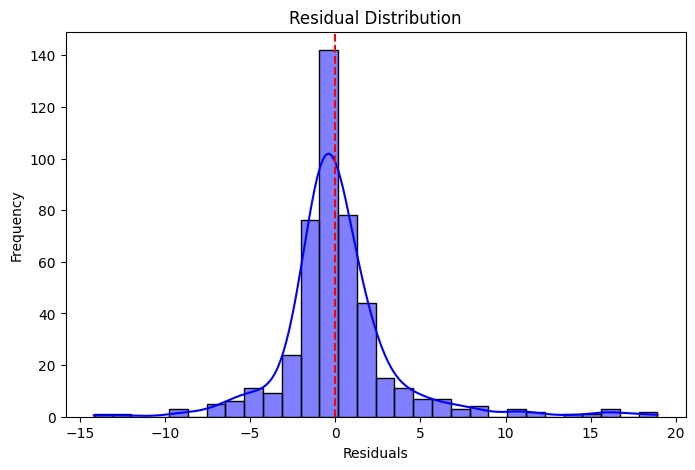

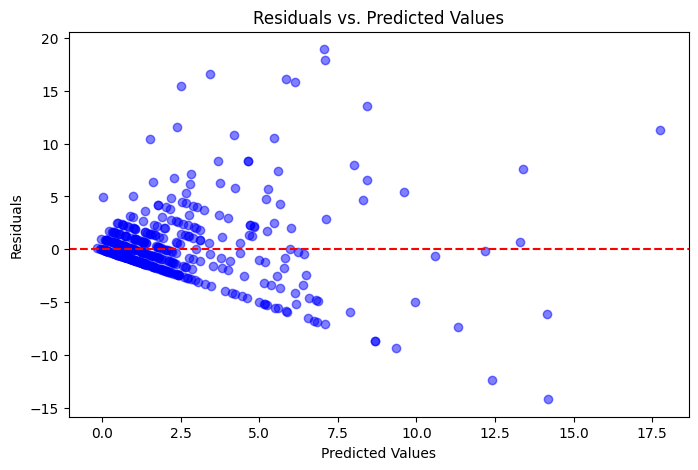

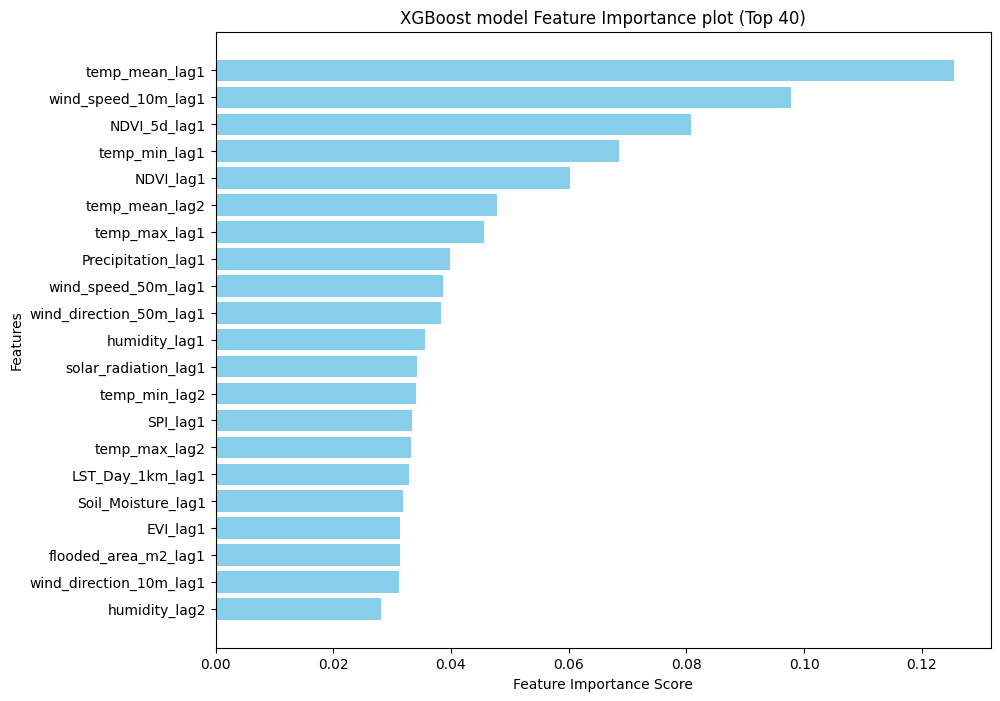

In [9]:
# Residuals plot 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

residuals = y_test - y_pred_xgb  # Calculate residuals

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

# scatter plot 
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_xgb, residuals, alpha=0.5, color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


# Ensure feature names are available
feature_names = X.columns  # Save original column names before scaling
# Feature importance
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order
sorted_features = np.array(feature_names)[sorted_idx]  # Use saved column names
# Select **Top 25** Features
top_n = 40  
top_features = sorted_features[:top_n]
top_importance = feature_importance[sorted_idx][:top_n]
# Plot Top 25 Features
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_importance, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title(f"XGBoost model Feature Importance plot (Top {top_n})")
plt.gca().invert_yaxis()
plt.show()